In [1]:
import os
import joblib
from time import time

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, TimeDistributed
from tensorflow.keras import Input, Model, callbacks
from tensorflow.keras.utils import plot_model as plm
from tensorflow.keras.activations import swish
from keras.callbacks import CSVLogger

from tensorflow.compat.v1.keras.backend import set_session
from scikeras.wrappers import KerasRegressor
from tcn import TCN, tcn_full_summary

import sys
sys.path.insert(0, '../MODL/INC/')
from data_load import data_load


#-------------------------------------------------------------------------
# .. Set configure

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config))


#-------------------------------------------------------------------------
# .. Data set

element = 'ALLV'
name_list = "./SHEL/namelist.input"

hp_lr = 0.009
hp_pd = 'same'
hp_ns = 1
hp_dl = [1,2,4,8,16,32,48]
hp_ldl = hp_dl[-1] # last dilation factor to make name of save model
hp_bn = True
hp_nf = 80
hp_dr = 0.07
hp_ks = 6

input_size = 6
output_size = 2
num_fct = 48
batch_size = 8
n_iter_search = 20
num_epoch = 600
dev_stn_id = 47105
tran_data_per = "2101_2104_2201_2204"

exp_name = "CNTL"
csv_outdir = './DAOU/LOSS/' + exp_name + '/'
model_outdir = './DAOU/MODL/' + exp_name + '/'
scalr_outdir = './DAOU/SCAL/' + exp_name + '/'
gifd_outdir = './GIFD/' + exp_name + '/'
log_outdir = './DAOU/LOGF/' + exp_name + '/'


if os.path.exists(csv_outdir) != True: os.makedirs(csv_outdir)
if os.path.exists(model_outdir) != True: os.makedirs(model_outdir)
if os.path.exists(scalr_outdir) != True: os.makedirs(scalr_outdir)
if os.path.exists(gifd_outdir) != True: os.makedirs(gifd_outdir)
if os.path.exists(log_outdir) != True: os.makedirs(log_outdir)


nwp_file = "../DAIO/nwp_data_47105"
obs_file = "../DAIO/obs_data_47105"

sel_dm_nwp_train, sel_dm_nwp_test, dm_obs_train, dm_obs_test = data_load(nwp_file, obs_file)

================================================== load data shape
(868, 49, 20)
(868, 49, 2)
================================================== split data shape
(109, 49, 20)
(109, 49, 2)
(61, 49, 20)
(61, 49, 2)
결측 합계:  1
shape of after drop
(108, 49, 20)
(108, 49, 2)
결측 합계:  5
shape of after drop
(56, 49, 20)
(56, 49, 2)
================================================== drop data shape
(108, 48, 6)
(108, 48, 2)
(56, 48, 6)
(56, 48, 2)


In [2]:
# .. 스케일링 및 데이터 분할
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, './INC')
from step_sampling_for_date import step_sampling_for_date
from hist_and_kde_for_split import hist_and_kde_for_split, hist_and_kde_for_split_UV

#-------------------------------------------------------------------------
# .. Normalize

output_size = 2

# .. initialaize
tr_b, tr_s, tr_f = sel_dm_nwp_train.shape[0], sel_dm_nwp_train.shape[1], sel_dm_nwp_train.shape[2]      
ts_b, ts_s, ts_f = sel_dm_nwp_test.shape[0], sel_dm_nwp_test.shape[1], sel_dm_nwp_test.shape[2]      

# .. get restorator with obs range
nwp_scaler = MinMaxScaler()   # copy default true
obs_scaler = MinMaxScaler()
nwp_scaler.fit(sel_dm_nwp_train.view().reshape(tr_b*tr_s, tr_f))
obs_scaler.fit(dm_obs_train.view().reshape(tr_b*tr_s, output_size))

# .. feature normalize   ( train seq, feature = test seq, feature )
nor_dm_nwp_train = nwp_scaler.transform(sel_dm_nwp_train.reshape(tr_b*tr_s, tr_f))
nor_dm_nwp_train = nor_dm_nwp_train.reshape(tr_b,tr_s,tr_f)
nor_dm_nwp_test = nwp_scaler.transform(sel_dm_nwp_test.reshape(ts_b*ts_s, ts_f))
nor_dm_nwp_test = nor_dm_nwp_test.reshape(ts_b,ts_s,ts_f)

nor_dm_obs_train = obs_scaler.transform(dm_obs_train.reshape(tr_b*tr_s, output_size))
nor_dm_obs_train = nor_dm_obs_train.reshape(tr_b,tr_s, output_size)
nor_dm_obs_test = obs_scaler.transform(dm_obs_test.reshape(ts_b*ts_s, output_size))
nor_dm_obs_test = nor_dm_obs_test.reshape(ts_b,ts_s, output_size)


print ('---------- Final training data shape')
print(type(nor_dm_nwp_train))
print ('tran nwp : ', nor_dm_nwp_train.shape)
print ('tran obs : ', nor_dm_obs_train.shape)
print ('test nwp : ', nor_dm_nwp_test.shape)
print ('test obs : ', nor_dm_obs_test.shape)


---------- Final training data shape
<class 'numpy.ndarray'>
tran nwp :  (108, 48, 6)
tran obs :  (108, 48, 2)
test nwp :  (56, 48, 6)
test obs :  (56, 48, 2)


In [41]:
#-------------------------------------------------------------------------
# .. Model load
from tensorflow.keras.models import load_model
#model_name = "../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf87_pdsame_ks6_dr0.07_dl48_ns1_2101_2104_2201_2204_47105.h5"

#hyper band
#model_name = "../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf85_pdsame_ks3_dr0.07_dl4_ns1_2101_2104_2201_2204_47105.h5"

#bayesian
model_name = "../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf95_pdsame_ks3_dr0.07_dl4_ns1_2101_2104_2201_2204_47105.h5"

print ("load_model: ", model_name)
model = load_model(model_name, custom_objects={'TCN':TCN} )

nor_pred_test_y = model.predict(nor_dm_nwp_test)
inv_pred_test = obs_scaler.inverse_transform(nor_pred_test_y.reshape(ts_b*ts_s, output_size))
inv_pred_test = inv_pred_test.reshape(ts_b,ts_s, output_size)
print(inv_pred_test.shape)

load_model:  ../MODL/DAOU/MODL/CNTL/tcn_modl_var6_e1000_bs8_lr0.009_nf95_pdsame_ks3_dr0.07_dl4_ns1_2101_2104_2201_2204_47105.h5
2/2 [==============================] - 1s 102ms/step
(56, 48, 2)


(56, 48)
(56, 48)
(56, 48)
        u_bias    v_bias    u_rmse    v_rmse  spd_bias  spd_rmse
ldps -0.590387  1.412058  2.871175  3.295231 -0.590387  2.871175
tcnm -0.291499  1.426280  1.742871  2.042848  0.590305  1.951745


<Axes: >

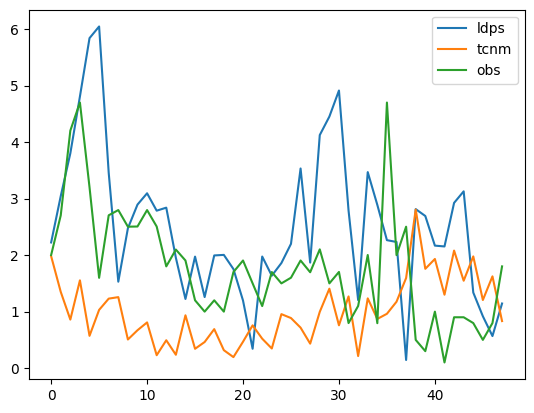

In [42]:
import numpy as np
import pandas as pd
%matplotlib inline

sys.path.insert(0, '../MODL/INC/')
from calc_stastics import bias_rmse
from uv_to_wind import uv_to_wind



def calc_bias(pred, target):
    bias = pred - target
    mean_bias = np.mean(bias, axis=0)
    return mean_bias

def calc_rmse(pred, target):
    se = (pred - target)**2
    rmse = np.sqrt( np.mean(se, axis=0) )
    return rmse



ndim_uv_to_wind = np.vectorize(uv_to_wind)
ldps_spd, ldps_dir = ndim_uv_to_wind(sel_dm_nwp_test[:,:,1], sel_dm_nwp_test[:,:,2])
tcnm_spd, tcnm_dir = ndim_uv_to_wind(inv_pred_test[:,:,0], inv_pred_test[:,:,1])
obsd_spd, obsd_dir = ndim_uv_to_wind(dm_obs_test[:,:,0], dm_obs_test[:,:,1])

print(ldps_spd.shape)
print(tcnm_spd.shape)
print(obsd_spd.shape)



# .. OBS spd, dir
# bias
ldps_u_bias = calc_bias(sel_dm_nwp_test[:,:,1], dm_obs_test[:,:,0])
ldps_v_bias = calc_bias(sel_dm_nwp_test[:,:,2], dm_obs_test[:,:,1])
tcnm_u_bias = calc_bias(inv_pred_test[:,:,0], dm_obs_test[:,:,0])
tcnm_v_bias = calc_bias(inv_pred_test[:,:,1], dm_obs_test[:,:,1])
ldps_u_rmse = calc_rmse(sel_dm_nwp_test[:,:,1], dm_obs_test[:,:,0])
ldps_v_rmse = calc_rmse(sel_dm_nwp_test[:,:,2], dm_obs_test[:,:,1])
tcnm_u_rmse = calc_rmse(inv_pred_test[:,:,0], dm_obs_test[:,:,0])
tcnm_v_rmse = calc_rmse(inv_pred_test[:,:,1], dm_obs_test[:,:,1])

ldps_spd_bias = calc_bias(sel_dm_nwp_test[:,:,1], dm_obs_test[:,:,0])
tcnm_spd_bias = calc_bias(tcnm_spd[:,:], dm_obs_test[:,:,0])
ldps_spd_rmse = calc_rmse(sel_dm_nwp_test[:,:,1], dm_obs_test[:,:,0])
tcnm_spd_rmse = calc_rmse(tcnm_spd[:,:], dm_obs_test[:,:,0])


error_put = {'u_bias': [np.mean(ldps_u_bias), np.mean(tcnm_u_bias)],
             'v_bias': [np.mean(ldps_v_bias), np.mean(tcnm_v_bias)],
             'u_rmse': [np.mean(ldps_u_rmse), np.mean(tcnm_u_rmse)],
             'v_rmse': [np.mean(ldps_v_rmse), np.mean(tcnm_v_rmse)],
             'spd_bias': [np.mean(ldps_spd_bias), np.mean(tcnm_spd_bias)],
             'spd_rmse': [np.mean(ldps_spd_rmse), np.mean(tcnm_spd_rmse)]
              }

error_df = pd.DataFrame(error_put, index=['ldps', 'tcnm'])
print(error_df)

sel_time = 40
put_df = {'ldps':ldps_spd[sel_time,:], 'tcnm':tcnm_spd[sel_time,:], 'obs': obsd_spd[sel_time,:] }
df = pd.DataFrame(data = put_df)
df.plot.line()

# rmse
#tobs_spd = tobs[:,:,:,:,0]
#tcnm_spd = tcnm[:,:,:,:,0]
#g128_spd_bias, g128_spd_rmse = bias_rmse( g128_spd, tobs_spd, dev_stn_id, 'G128' )
#tcnm_spd_bias, tcnm_spd_rmse = bias_rmse( tcnm_spd, tobs_spd, dev_stn_id, 'TCN1' )